In [1]:
#IMPORTAR LAS LIBRERIAS NECESARIAS
# Librerías básicas para manejo de datos
import pandas as pd 
import numpy as np   

# Librerías para visualización
import matplotlib.pyplot as plt  
import seaborn as sns           

# Librerías de scikit-learn para machine learning
from sklearn.model_selection import train_test_split  # Para dividir datos
from sklearn.preprocessing import StandardScaler      # Para escalar datos

# Modelos de regresión (vamos a usar 3 modelos simples)
from sklearn.linear_model import LinearRegression    # Regresión lineal simple
from sklearn.tree import DecisionTreeRegressor      # Árbol de decisión
from sklearn.ensemble import RandomForestRegressor  # Random Forest

# Métricas para evaluar nuestros modelos
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Para que los gráficos se vean mejor
plt.style.use('default')
sns.set_palette("husl")

# Ignorar advertencias para que el notebook se vea más limpio
import warnings
warnings.filterwarnings('ignore')

#Para lectura de dataset en kaggle
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [2]:
# Set the path to the file you'd like to load
file_path = "train.csv"

# Load the latest version
df_completo = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "adilshamim8/predict-calorie-expenditure",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df_completo.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [3]:
#EXPLORACION DE LOS DATOS

# Ver las primeras filas para entender qué datos tenemos
print("\nPrimeras 5 filas del dataset:")
print(df_completo.head())

# Ver información general del dataset
print("\nInformación general del dataset:")
print(df_completo.info())

# Ver cuántos registros tenemos
print(f"\nTotal de registros: {len(df_completo):,}")
print(f"Total de columnas: {df_completo.shape[1]}")


Primeras 5 filas del dataset:
   id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
0   0    male   36   189.0    82.0      26.0       101.0       41.0     150.0
1   1  female   64   163.0    60.0       8.0        85.0       39.7      34.0
2   2  female   51   161.0    64.0       7.0        84.0       39.8      29.0
3   3    male   20   192.0    90.0      25.0       105.0       40.7     140.0
4   4  female   38   166.0    61.0      25.0       102.0       40.6     146.0

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  7500

In [4]:
#ANÁLISIS DE TIPOS DE VARIABLES

# Identificar qué columnas son numéricas y cuáles categóricas
columnas_numericas = df_completo.select_dtypes(include=['int64', 'float64']).columns.tolist()
columnas_categoricas = df_completo.select_dtypes(include=['object']).columns.tolist()

print(f"\nVariables numéricas: {columnas_numericas}")
print(f"Variables categóricas: {columnas_categoricas}")

# Ver estadísticas básicas de las variables numéricas
print("\nEstadísticas básicas de variables numéricas:")
print(df_completo[columnas_numericas].describe().round(2))


Variables numéricas: ['id', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']
Variables categóricas: ['Sex']

Estadísticas básicas de variables numéricas:
              id        Age     Height     Weight   Duration  Heart_Rate  \
count  750000.00  750000.00  750000.00  750000.00  750000.00   750000.00   
mean   374999.50      41.42     174.70      75.15      15.42       95.48   
std    216506.50      15.18      12.82      13.98       8.35        9.45   
min         0.00      20.00     126.00      36.00       1.00       67.00   
25%    187499.75      28.00     164.00      63.00       8.00       88.00   
50%    374999.50      40.00     174.00      74.00      15.00       95.00   
75%    562499.25      52.00     185.00      87.00      23.00      103.00   
max    749999.00      79.00     222.00     132.00      30.00      128.00   

       Body_Temp   Calories  
count  750000.00  750000.00  
mean       40.04      88.28  
std         0.78      62.40  
min        

In [5]:
#VALIDAR VALORES FALTANTES

# Contar valores faltantes en cada columna
valores_faltantes = df_completo.isnull().sum()

# Mostrar solo si hay valores faltantes
if valores_faltantes.sum() == 0:
    print("\nSin valores faltantes en el dataset")
else:
    print("\nSe encontraron valores faltantes:")
    print(valores_faltantes[valores_faltantes > 0])


Sin valores faltantes en el dataset



Valores atípicos por columna:
  Age: 0 outliers (0.0%)
  Height: 14 outliers (0.0%)
  Weight: 9 outliers (0.0%)
  Duration: 0 outliers (0.0%)
  Heart_Rate: 36 outliers (0.0%)
  Body_Temp: 14919 outliers (2.0%)
  Calories: 139 outliers (0.0%)


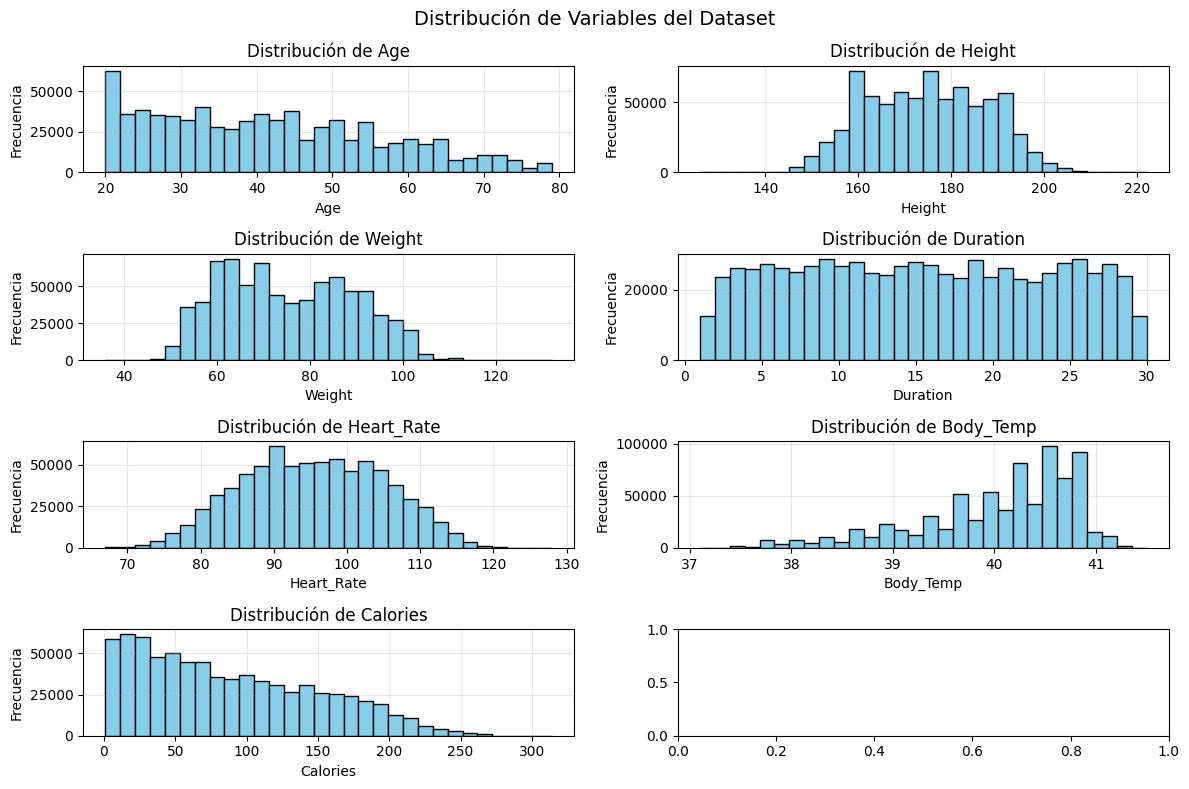

In [6]:
##DETECTAR VALORES ATÍPICOS (OUTLIERS)

# Función simple para detectar outliers
def contar_outliers(columna):
    """
    Esta función cuenta cuántos valores atípicos hay en una columna.
    Un valor es atípico si está muy lejos de la mayoría de los datos.
    """
    # Calcular cuartiles (valores que dividen los datos en 4 partes)
    Q1 = columna.quantile(0.25)  # 25% de los datos están por debajo
    Q3 = columna.quantile(0.75)  # 75% de los datos están por debajo
    IQR = Q3 - Q1  # Rango intercuartílico
    
    # Definir límites para outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Contar valores fuera de los límites
    outliers = ((columna < limite_inferior) | (columna > limite_superior)).sum()
    return outliers

# Contar outliers en cada columna numérica (excepto 'id')
print("\nValores atípicos por columna:")
for col in columnas_numericas:
    if col != 'id':  # No analizar la columna id
        n_outliers = contar_outliers(df_completo[col])
        porcentaje = (n_outliers / len(df_completo)) * 100
        print(f"  {col}: {n_outliers} outliers ({porcentaje:.1f}%)")

##VISUALIZAR LAS DISTRIBUCIONES CON HISTOGRAMAS

# Seleccionar columnas para graficar (sin incluir 'id')
columnas_graficar = [col for col in columnas_numericas if col != 'id'][:7]

# Crear una figura con subgráficos
fig, axes = plt.subplots(4, 2, figsize=(12, 8))
axes = axes.flatten()  # Convertir en lista plana

for i, columna in enumerate(columnas_graficar):
    if i < len(axes):
        # Crear histograma
        axes[i].hist(df_completo[columna], bins=30, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribución de {columna}')
        axes[i].set_xlabel(columna)
        axes[i].set_ylabel('Frecuencia')
        axes[i].grid(True, alpha=0.3)

plt.suptitle('Distribución de Variables del Dataset', fontsize=14)
plt.tight_layout()
plt.show()


📊 Correlación de cada variable con Calories:
(Valores cercanos a 1 o -1 indican fuerte correlación)
----------------------------------------
Duration        -> +0.960 (FUERTE)
Heart_Rate      -> +0.909 (FUERTE)
Body_Temp       -> +0.829 (FUERTE)
Age             -> +0.146 (MUY DÉBIL)
Weight          -> +0.016 (MUY DÉBIL)
id              -> +0.001 (MUY DÉBIL)
Height          -> -0.004 (MUY DÉBIL)


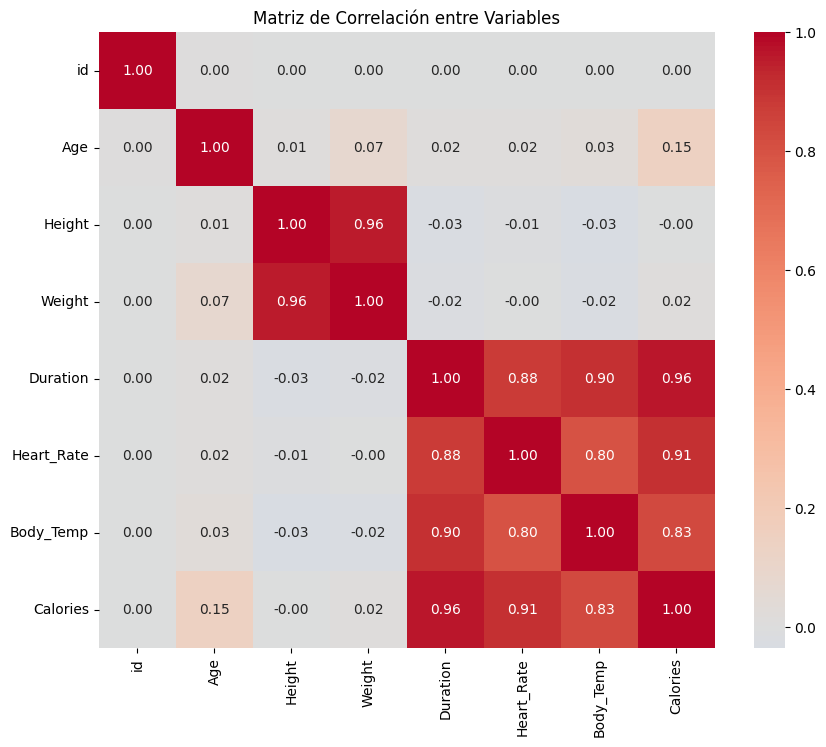

In [7]:
##ANÁLISIS DE CORRELACIONES (SI EXISTE LA COLUMNA CALORIES)


# Verificar si tenemos la columna Calories
if 'Calories' in df_completo.columns:
    # Calcular correlaciones solo con variables numéricas
    correlaciones = df_completo[columnas_numericas].corr()['Calories'].sort_values(ascending=False)
    
    print("\n📊 Correlación de cada variable con Calories:")
    print("(Valores cercanos a 1 o -1 indican fuerte correlación)")
    print("-" * 40)
    
    for variable, correlacion in correlaciones.items():
        if variable != 'Calories':
            # Interpretar la correlación
            if abs(correlacion) >= 0.7:
                fuerza = "FUERTE"
            elif abs(correlacion) >= 0.5:
                fuerza = "MODERADA"
            elif abs(correlacion) >= 0.3:
                fuerza = "DÉBIL"
            else:
                fuerza = "MUY DÉBIL"
            
            print(f"{variable:15} -> {correlacion:+.3f} ({fuerza})")
    
    # Crear mapa de calor de correlaciones
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_completo[columnas_numericas].corr(), 
                annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True)
    plt.title('Matriz de Correlación entre Variables')
    plt.show()
    
else:
    print("No se encuentra la columna calories")

In [8]:
#PREPROCESAMIENTO DE DATOS


# Hacer una copia para no modificar el dataset original
df_procesado = df_completo.copy()

#  Codificar la variable categórica 'Sex' (si existe)
if 'Sex' in df_procesado.columns:

    # Ver qué valores únicos tiene
    print(f"  Valores originales: {df_procesado['Sex'].unique()}")
    
    # Convertir a números: Female=0, Male=1
    df_procesado['Sex'] = df_procesado['Sex'].map({'female': 0, 'male': 1})
    
    print(f"  Valores codificados: {df_procesado['Sex'].unique()}")
    print("  (0 = Female, 1 = Male)")

#Eliminar la columna 'id' ya que no aporta información útil
if 'id' in df_procesado.columns:
    df_procesado = df_procesado.drop('id', axis=1)
    print("\n Columna 'id' eliminada (no es útil para el modelo)")

print("\nPreprocesamiento completado")
print(f"   Shape del dataset procesado: {df_procesado.shape}")

  Valores originales: ['male' 'female']
  Valores codificados: [1 0]
  (0 = Female, 1 = Male)

 Columna 'id' eliminada (no es útil para el modelo)

Preprocesamiento completado
   Shape del dataset procesado: (750000, 8)


In [9]:
##SEPARAR DATOS DE ENTRENAMIENTO Y TEST


# Dividir el dataset en 80-20: primeros 600,000 para entrenar, últimos 150,000 para test
df_train = df_procesado.iloc[:600000].copy()  # Primeros 600k registros
df_test = df_procesado.iloc[600000:].copy()    # Últimos 150k registros
    
print(f"\nDataset de entrenamiento: {len(df_train):,} registros")
print(f"Dataset de prueba: {len(df_test):,} registros")
    
# Separar features (X) y target (y) para entrenamiento
X_train = df_train.drop('Calories', axis=1)  # Todo excepto Calories
y_train = df_train['Calories']  # Solo Calories
    
# Separar features (X) y target (y) para test
X_test = df_test.drop('Calories', axis=1)  # Todo excepto Calories
y_test = df_test['Calories']  # Solo Calories (las guardamos para evaluar)
    
print("\n Dataset de Train y Test listos")


Dataset de entrenamiento: 600,000 registros
Dataset de prueba: 150,000 registros

 Dataset de Train y Test listos


In [10]:
#ESCALAR LOS DATOS

# Crear el escalador
scaler = StandardScaler()
    
# Ajustar el escalador con los datos de entrenamiento y transformar
X_train_scaled = scaler.fit_transform(X_train)
    
# Transformar los datos de prueba (sin ajustar de nuevo)
X_test_scaled = scaler.transform(X_test)
    
print("Datos escalados correctamente")

Datos escalados correctamente


In [11]:
#ENTRENAR MODELOS

# Diccionario para guardar nuestros modelos
modelos = {}
    
# MODELO 1: Regresión Lineal
print("\n Entrenando Regresión Lineal")
modelo_lineal = LinearRegression()
modelo_lineal.fit(X_train_scaled, y_train)
modelos['Regresión Lineal'] = modelo_lineal
print("Modelo entrenado correctamente")
    
# MODELO 2: Árbol de Decisión
print("\n Entrenando Árbol de Decisión")
modelo_arbol = DecisionTreeRegressor(random_state=42, max_depth=10)
modelo_arbol.fit(X_train_scaled, y_train)
modelos['Árbol de Decisión'] = modelo_arbol
print("Modelo entrenado correctamente")
    
# MODELO 3: Random Forest
print("\n Entrenando Random Forest")
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
modelo_rf.fit(X_train_scaled, y_train)
modelos['Random Forest'] = modelo_rf
print("Modelo entrenado correctamente")


 Entrenando Regresión Lineal
Modelo entrenado correctamente

 Entrenando Árbol de Decisión
Modelo entrenado correctamente

 Entrenando Random Forest
Modelo entrenado correctamente


In [13]:
#EVALUAR MODELOS

# Diccionario para guardar las métricas
resultados = {
    'Modelo': [],
    'MAE': [],
    'RMSE': [],
    'R2': []
}
    
# Evaluar cada modelo
for nombre, modelo in modelos.items():
        # Hacer predicciones
        y_pred = modelo.predict(X_test_scaled)
        
        # Calcular métricas
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Guardar resultados
        resultados['Modelo'].append(nombre)
        resultados['MAE'].append(mae)
        resultados['RMSE'].append(rmse)
        resultados['R2'].append(r2)
        
        print(f"\n{nombre}:")
        print(f"   MAE:  {mae:.2f} calorías (error promedio absoluto)")
        print(f"   RMSE: {rmse:.2f} calorías (error cuadrático medio)")
        print(f"   R²:   {r2:.4f} (% de varianza explicada, más cerca de 1 es mejor)")
    
# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados)
    
#TABLA COMPARATIVA DE MODELOS
print(df_resultados.to_string(index=False))


Regresión Lineal:
   MAE:  8.10 calorías (error promedio absoluto)
   RMSE: 11.11 calorías (error cuadrático medio)
   R²:   0.9682 (% de varianza explicada, más cerca de 1 es mejor)

Árbol de Decisión:
   MAE:  3.67 calorías (error promedio absoluto)
   RMSE: 5.57 calorías (error cuadrático medio)
   R²:   0.9920 (% de varianza explicada, más cerca de 1 es mejor)

Random Forest:
   MAE:  3.26 calorías (error promedio absoluto)
   RMSE: 4.97 calorías (error cuadrático medio)
   R²:   0.9937 (% de varianza explicada, más cerca de 1 es mejor)
           Modelo      MAE      RMSE       R2
 Regresión Lineal 8.098810 11.111780 0.968250
Árbol de Decisión 3.671209  5.569557 0.992023
    Random Forest 3.263119  4.968570 0.993652


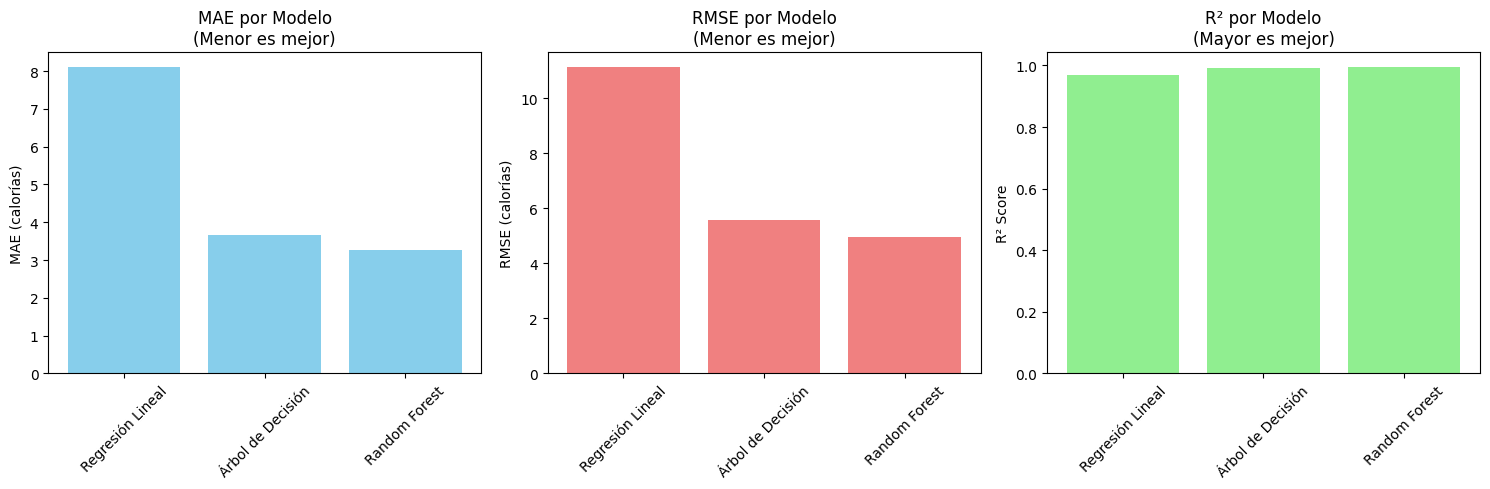

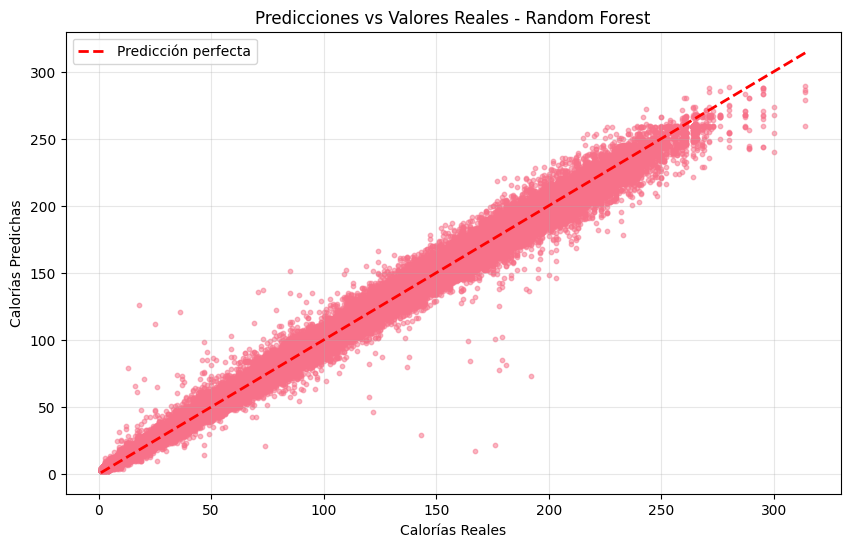

In [14]:
#VISUALIZACIÓN DE RESULTADOS

# Gráfico 1: Comparación de métricas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # MAE
axes[0].bar(df_resultados['Modelo'], df_resultados['MAE'], color='skyblue')
axes[0].set_title('MAE por Modelo\n(Menor es mejor)')
axes[0].set_ylabel('MAE (calorías)')
axes[0].tick_params(axis='x', rotation=45)
    
# RMSE
axes[1].bar(df_resultados['Modelo'], df_resultados['RMSE'], color='lightcoral')
axes[1].set_title('RMSE por Modelo\n(Menor es mejor)')
axes[1].set_ylabel('RMSE (calorías)')
axes[1].tick_params(axis='x', rotation=45)
    
# R2
axes[2].bar(df_resultados['Modelo'], df_resultados['R2'], color='lightgreen')
axes[2].set_title('R² por Modelo\n(Mayor es mejor)')
axes[2].set_ylabel('R² Score')
axes[2].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()
    
# Gráfico 2: Predicciones vs Valores Reales (para el mejor modelo)
mejor_modelo_nombre = df_resultados.loc[df_resultados['R2'].idxmax(), 'Modelo']
mejor_modelo = modelos[mejor_modelo_nombre]
y_pred_mejor = mejor_modelo.predict(X_test_scaled)
    
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_mejor, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Predicción perfecta')
plt.xlabel('Calorías Reales')
plt.ylabel('Calorías Predichas')
plt.title(f'Predicciones vs Valores Reales - {mejor_modelo_nombre}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


📊 Variables más importantes para predecir calorías:
   (según Random Forest)
----------------------------------------
   Duration        -> 93.2%
   Heart_Rate      -> 4.0%
   Age             -> 2.1%
   Sex             -> 0.6%
   Weight          -> 0.1%
   Height          -> 0.0%
   Body_Temp       -> 0.0%


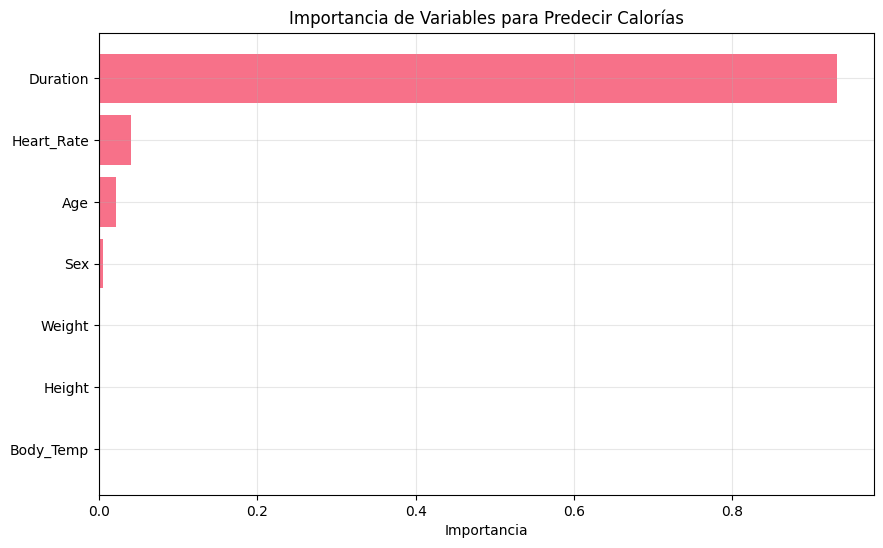

In [16]:
#IMPORTANCIA DE VARIABLES (SOLO PARA RANDOM FOREST)
if 'Random Forest' in modelos:
    # Obtener importancia de características
    importancias = modelo_rf.feature_importances_
    nombres_features = X_train.columns
        
    # Crear DataFrame y ordenar
    df_importancia = pd.DataFrame({
        'Variable': nombres_features,
        'Importancia': importancias
    }).sort_values('Importancia', ascending=False)
        
    print("\n📊 Variables más importantes para predecir calorías:")
    print("   (según Random Forest)")
    print("-" * 40)
    for idx, row in df_importancia.iterrows():
        porcentaje = row['Importancia'] * 100
        print(f"   {row['Variable']:15} -> {porcentaje:.1f}%")
        
    # Gráfico de importancia
    plt.figure(figsize=(10, 6))
    plt.barh(df_importancia['Variable'], df_importancia['Importancia'])
    plt.xlabel('Importancia')
    plt.title('Importancia de Variables para Predecir Calorías')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.show()

In [17]:
# Set the path to the file you'd like to load
file_path = "test.csv"

# Load the latest version
df_test = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "adilshamim8/predict-calorie-expenditure",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df_test.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


In [18]:
##SIMULAR USO CON DATOS DE TEST REALES (SIN CALORIES)

    
print("\n Simulando un escenario real donde no conocemos las calorías con el archivo test del dataset:")
    
# Simular datos de test sin la columna Calories
X_test_sin_calories = df_test.copy()
    
print(f"   - Tenemos {len(X_test_sin_calories):,} registros sin etiquetas")
print("   - Usaremos el mejor modelo para predecir las calorías")
    
# Hacer predicciones
predicciones_finales = mejor_modelo.predict(X_test_scaled)
    
# Mostrar algunas predicciones de ejemplo
print("\n📊 Ejemplos de predicciones (primeros 10 registros):")
print("-" * 50)
print("Registro | Calorías Predichas | Calorías Reales | Diferencia")
print("-" * 50)
    
for i in range(10):
    pred = predicciones_finales[i]
    real = y_test.iloc[i]
    diff = abs(pred - real)
    print(f"    {i+1:3d}  |      {pred:7.1f}      |     {real:7.1f}     |   {diff:6.1f}")


 Simulando un escenario real donde no conocemos las calorías con el archivo test del dataset:
   - Tenemos 250,000 registros sin etiquetas
   - Usaremos el mejor modelo para predecir las calorías

📊 Ejemplos de predicciones (primeros 10 registros):
--------------------------------------------------
Registro | Calorías Predichas | Calorías Reales | Diferencia
--------------------------------------------------
      1  |        150.6      |       148.0     |      2.6
      2  |         46.3      |        48.0     |      1.7
      3  |        160.4      |       158.0     |      2.4
      4  |        104.7      |       105.0     |      0.3
      5  |         65.6      |        65.0     |      0.6
      6  |        125.3      |       130.0     |      4.7
      7  |         57.1      |        52.0     |      5.1
      8  |        233.2      |       239.0     |      5.8
      9  |         44.0      |        46.0     |      2.0
     10  |         10.0      |        11.0     |      1.0
